Loaded model: ./../train4/models_gridsearch_with_radius/RandomForest_best.joblib
Model n_features_in_: 10404
Found 5554 images (excluded annotated_*)
Per-image summary saved to: ./models_gridsearch_with_radius\eval_summary_all.csv

=== Evaluation on annotated images ===
n_samples (annotated) = 5554
R2 (cx): 0.8388 | R2 (cy): 0.6994 | R2 (r): 0.7352
MAE (cx): 3.991px | MAE (cy): 2.380px | MAE (r): 1.836px
RMSE (r): 2.348px
Euclid center error: mean=5.108px | median=3.686px | max=49.039px

--- AGGREGATE (all targets concatenated) ---
Overall R2: 0.9526
Overall MAE: 2.736px
Overall MSE: 18.560 (px^2) | Overall RMSE: 4.308px

--- Euclidean-error stats (center distance) ---
EMSE (mean squared euclid error): 50.169 (px^2)
EMRMSE (sqrt EMSE): 7.083px
Normalized Euclid err (mean): 0.159 | median: 0.117 (unit = fraction of gt_r)
Saved aggregate summary to ./models_gridsearch_with_radius\eval_summary_metrics.json
Saved plots to ./models_gridsearch_with_radius:
 - ./models_gridsearch_with_radius\

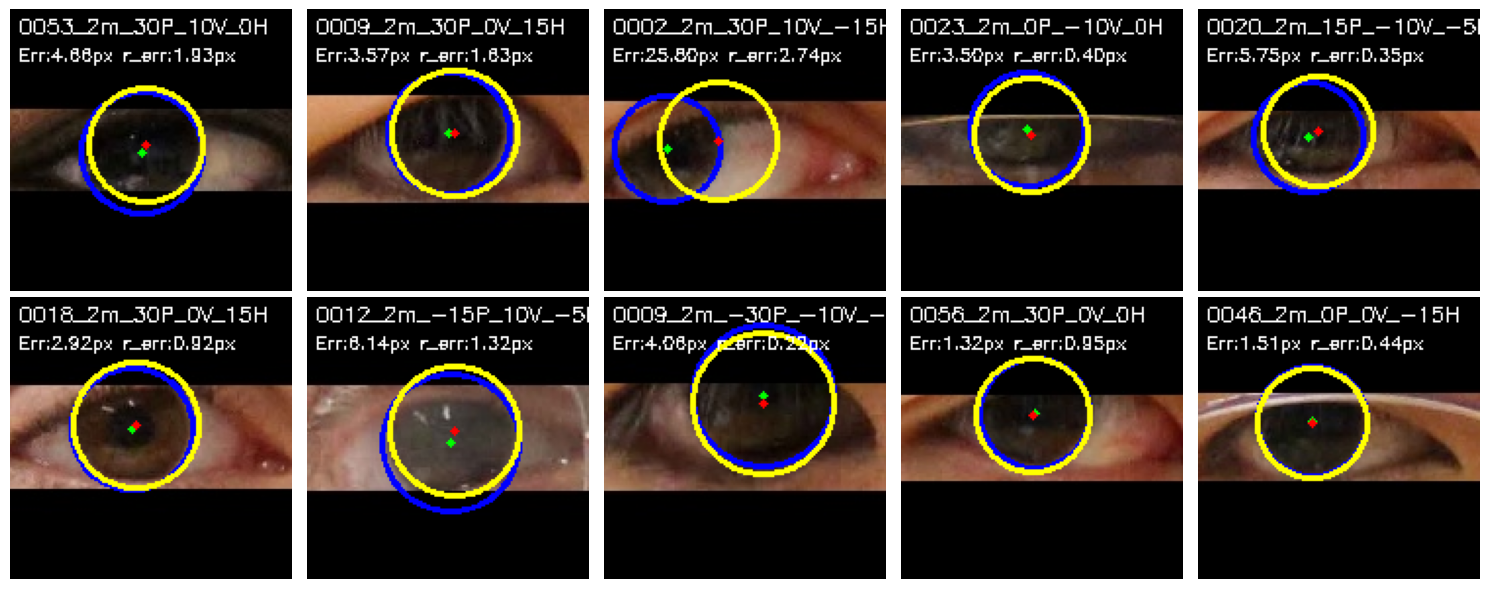

Saved sample grid to ./models_gridsearch_with_radius\sample_10_examples.png
Evaluation complete.


In [9]:
import os
import glob
import random
import joblib
import math
import warnings
import json

import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ------------ ปรับ path ตามโปรเจคคุณ ------------
IMG_DIR    = "./../data/Right/Image144x144"
ANN_DIR    = "./../data/Right/Annotation144x144"
MODEL_PATH = "./../train4/models_gridsearch_with_radius/RandomForest_best.joblib"
MODEL_SAVE_DIR = "./models_gridsearch_with_radius"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# HOG / image params (ต้องตรงกับตอนเทรน)
RESIZED = (144, 144)   # (width, height)
HOG_PIXELS_PER_CELL = (8, 8)
HOG_CELLS_PER_BLOCK = (2, 2)

random.seed(42)
np.random.seed(42)

# ---------- helpers ----------
def extract_hog_from_bgr(img_bgr, size=RESIZED):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (size[0], size[1]), interpolation=cv2.INTER_AREA)
    feats = hog(resized,
                pixels_per_cell=HOG_PIXELS_PER_CELL,
                cells_per_block=HOG_CELLS_PER_BLOCK,
                feature_vector=True)
    return feats, resized

def read_annotation_txt(txt_path):
    if not os.path.exists(txt_path):
        return None
    with open(txt_path, "r") as f:
        for line in f:
            toks = line.strip().split()
            if len(toks) >= 3:
                try:
                    cx = float(toks[0]); cy = float(toks[1]); r = float(toks[2])
                    return (cx, cy, r)
                except:
                    continue
    return None

def safe_predict_xy_r(model, feats):
    X = np.asarray(feats).reshape(1, -1).astype(np.float32)
    pred = model.predict(X)
    pred = np.array(pred).reshape(-1)
    if pred.size < 3:
        raise ValueError("predict result size < 3")
    px, py, pr = float(pred[0]), float(pred[1]), float(pred[2])
    # normalized -> pixel (on RESIZED)
    if 0.0 <= px <= 1.0 and 0.0 <= py <= 1.0:
        px_pix = px * RESIZED[0]
        py_pix = py * RESIZED[1]
    else:
        px_pix = px
        py_pix = py
    if 0.0 <= pr <= 1.0:
        pr_pix = pr * ((RESIZED[0] + RESIZED[1]) / 2.0)
    else:
        pr_pix = pr
    return px_pix, py_pix, pr_pix

def euclid(a,b):
    return math.hypot(a[0]-b[0], a[1]-b[1])

# ---------- load model ----------
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model not found: {MODEL_PATH}")
model = joblib.load(MODEL_PATH)
print("Loaded model:", MODEL_PATH)
print("Model n_features_in_:", getattr(model, "n_features_in_", None))

# ---------- list images (exclude files starting with annotated_) ----------
images = sorted(glob.glob(os.path.join(IMG_DIR, "*.jpg")) + glob.glob(os.path.join(IMG_DIR, "*.png")) + glob.glob(os.path.join(IMG_DIR, "*.jpeg")))
images = [p for p in images if not os.path.basename(p).lower().startswith("annotated_")]
print(f"Found {len(images)} images (excluded annotated_*)")

if len(images) == 0:
    raise RuntimeError("No images after filter. Check IMG_DIR and filenames.")

# ---------- Evaluate on all images that have annotation ----------
records = []
for img_path in images:
    base = os.path.splitext(os.path.basename(img_path))[0]
    ann_path = os.path.join(ANN_DIR, base + ".txt")
    gt = read_annotation_txt(ann_path)  # None if no annotation
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print("Cannot read:", img_path)
        continue

    feats, resized = extract_hog_from_bgr(img_bgr, size=RESIZED)
    # feature length check
    nfeat = getattr(model, "n_features_in_", None)
    if nfeat is not None and feats.size != nfeat:
        print(f"[WARN] feat len mismatch for {base}: {feats.size} vs {nfeat}; skipping")
        continue
    try:
        px_pix, py_pix, pr_pix = safe_predict_xy_r(model, feats)
    except Exception as e:
        print("Predict error for", base, e)
        continue

    pred_cx, pred_cy, pred_r = px_pix, py_pix, pr_pix

    rec = {
        "file": base,
        "pred_cx": pred_cx, "pred_cy": pred_cy, "pred_r": pred_r,
        "gt_cx": None, "gt_cy": None, "gt_r": None,
        "euclid_err": None, "r_err": None
    }
    if gt is not None:
        gt_cx, gt_cy, gt_r = gt
        rec["gt_cx"] = gt_cx; rec["gt_cy"] = gt_cy; rec["gt_r"] = gt_r
        rec["euclid_err"] = euclid((pred_cx, pred_cy), (gt_cx, gt_cy))
        rec["r_err"] = abs(pred_r - gt_r)
    records.append(rec)

# make dataframe and save
df = pd.DataFrame(records)
eval_csv = os.path.join(MODEL_SAVE_DIR, "eval_summary_all.csv")
df.to_csv(eval_csv, index=False)
print(f"Per-image summary saved to: {eval_csv}")

# ---------- Compute metrics using only rows that have ground-truth (improved & aggregate) ----------
valid = df[df["gt_cx"].notnull()].copy()
if len(valid) == 0:
    print("No annotated images found for evaluation.")
else:
    # ----- per-target (as before) -----
    r2_cx = r2_score(valid["gt_cx"], valid["pred_cx"])
    r2_cy = r2_score(valid["gt_cy"], valid["pred_cy"])
    r2_r  = r2_score(valid["gt_r"], valid["pred_r"])
    mae_cx = mean_absolute_error(valid["gt_cx"], valid["pred_cx"])
    mae_cy = mean_absolute_error(valid["gt_cy"], valid["pred_cy"])
    mae_r  = mean_absolute_error(valid["gt_r"], valid["pred_r"])
    rmse_r = math.sqrt(mean_squared_error(valid["gt_r"], valid["pred_r"]))
    eu_mean = valid["euclid_err"].mean()
    eu_median = valid["euclid_err"].median()
    eu_max = valid["euclid_err"].max()

    # ----- AGGREGATE metrics across all targets (concatenate targets) -----
    # Flatten gt/pred for cx, cy, r into single vectors (keeps units = pixels)
    y_true_concat = np.concatenate([
        valid["gt_cx"].to_numpy(),
        valid["gt_cy"].to_numpy(),
        valid["gt_r"].to_numpy()
    ])
    y_pred_concat = np.concatenate([
        valid["pred_cx"].to_numpy(),
        valid["pred_cy"].to_numpy(),
        valid["pred_r"].to_numpy()
    ])

    # overall metrics
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        r2_overall = r2_score(y_true_concat, y_pred_concat)
    mae_overall = mean_absolute_error(y_true_concat, y_pred_concat)
    mse_overall = mean_squared_error(y_true_concat, y_pred_concat)
    rmse_overall = math.sqrt(mse_overall)

    # EMSE: mean squared Euclidean error of center (euclid_err squared mean)
    eu_sq = (valid["euclid_err"] ** 2).to_numpy()
    emse_euclid = np.mean(eu_sq)
    emrmse_euclid = math.sqrt(emse_euclid)

    # normalized euclid (divide by gt radius) - robust (avoid zero)
    eps = 1e-6
    norm_eu = (valid["euclid_err"].to_numpy() / (valid["gt_r"].to_numpy() + eps))
    norm_eu_mean = np.mean(norm_eu)
    norm_eu_median = np.median(norm_eu)

    # print results
    print("\n=== Evaluation on annotated images ===")
    print(f"n_samples (annotated) = {len(valid)}")
    print(f"R2 (cx): {r2_cx:.4f} | R2 (cy): {r2_cy:.4f} | R2 (r): {r2_r:.4f}")
    print(f"MAE (cx): {mae_cx:.3f}px | MAE (cy): {mae_cy:.3f}px | MAE (r): {mae_r:.3f}px")
    print(f"RMSE (r): {rmse_r:.3f}px")
    print(f"Euclid center error: mean={eu_mean:.3f}px | median={eu_median:.3f}px | max={eu_max:.3f}px")

    print("\n--- AGGREGATE (all targets concatenated) ---")
    print(f"Overall R2: {r2_overall:.4f}")
    print(f"Overall MAE: {mae_overall:.3f}px")
    print(f"Overall MSE: {mse_overall:.3f} (px^2) | Overall RMSE: {rmse_overall:.3f}px")

    print("\n--- Euclidean-error stats (center distance) ---")
    print(f"EMSE (mean squared euclid error): {emse_euclid:.3f} (px^2)")
    print(f"EMRMSE (sqrt EMSE): {emrmse_euclid:.3f}px")
    print(f"Normalized Euclid err (mean): {norm_eu_mean:.3f} | median: {norm_eu_median:.3f} (unit = fraction of gt_r)")

    # save a compact summary JSON/CSV
    summary = {
        "n_annotated": int(len(valid)),
        "r2_cx": float(r2_cx), "r2_cy": float(r2_cy), "r2_r": float(r2_r),
        "mae_cx": float(mae_cx), "mae_cy": float(mae_cy), "mae_r": float(mae_r),
        "rmse_r": float(rmse_r),
        "eu_mean": float(eu_mean), "eu_median": float(eu_median), "eu_max": float(eu_max),
        "r2_overall": float(r2_overall), "mae_overall": float(mae_overall), "mse_overall": float(mse_overall),
        "rmse_overall": float(rmse_overall), "emse_euclid": float(emse_euclid),
        "emrmse_euclid": float(emrmse_euclid),
        "norm_eu_mean": float(norm_eu_mean)
    }
    with open(os.path.join(MODEL_SAVE_DIR, "eval_summary_metrics.json"), "w") as f:
        json.dump(summary, f, indent=2)
    print(f"Saved aggregate summary to {os.path.join(MODEL_SAVE_DIR, 'eval_summary_metrics.json')}")

    # ----- Useful visualizations -----
    # 1) histogram of euclid errors
    plt.figure(figsize=(6,4))
    plt.hist(valid["euclid_err"].to_numpy(), bins=40)
    plt.title("Histogram of Euclidean center errors (px)")
    plt.xlabel("Euclid error (px)")
    plt.ylabel("count")
    plt.tight_layout()
    hist_path = os.path.join(MODEL_SAVE_DIR, "hist_euclid_err.png")
    plt.savefig(hist_path)
    plt.close()

    # 2) scatter pred vs gt for cx, cy, r (three small plots)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.scatter(valid["gt_cx"], valid["pred_cx"], s=6)
    plt.xlabel("gt_cx"); plt.ylabel("pred_cx"); plt.title("cx: pred vs gt")
    plt.plot([0, RESIZED[0]],[0, RESIZED[0]], linestyle='--')
    plt.subplot(1,3,2)
    plt.scatter(valid["gt_cy"], valid["pred_cy"], s=6)
    plt.xlabel("gt_cy"); plt.ylabel("pred_cy"); plt.title("cy: pred vs gt")
    plt.plot([0, RESIZED[1]],[0, RESIZED[1]], linestyle='--')
    plt.subplot(1,3,3)
    plt.scatter(valid["gt_r"], valid["pred_r"], s=6)
    plt.xlabel("gt_r"); plt.ylabel("pred_r"); plt.title("r: pred vs gt")
    mx = max(valid["gt_r"].max(), valid["pred_r"].max())
    plt.plot([0, mx],[0, mx], linestyle='--')
    plt.tight_layout()
    scatter_path = os.path.join(MODEL_SAVE_DIR, "scatter_pred_vs_gt.png")
    plt.savefig(scatter_path)
    plt.close()
    print(f"Saved plots to {MODEL_SAVE_DIR}:")
    print(" -", hist_path)
    print(" -", scatter_path)

    # 3) save worst cases (top-K) as annotated images for inspection
    K = min(20, len(valid))
    worst = valid.sort_values("euclid_err", ascending=False).head(K)
    worst_dir = os.path.join(MODEL_SAVE_DIR, "worst_cases")
    os.makedirs(worst_dir, exist_ok=True)
    for idx, r in worst.iterrows():
        fname = r["file"]
        img_path = None
        # try find full path from original images list
        for ext in [".jpg", ".png", ".jpeg"]:
            candidate = os.path.join(IMG_DIR, fname + ext)
            if os.path.exists(candidate):
                img_path = candidate
                break
        if img_path is None:
            continue
        im = cv2.imread(img_path)
        im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        # draw GT and pred (colors for display; cv2 expects BGR but we're drawing on RGB array - it's okay for visualization)
        if pd.notnull(r["gt_cx"]):
            cv2.circle(im_rgb, (int(round(r["gt_cx"])), int(round(r["gt_cy"]))), 2, (0,255,0), -1)
            cv2.circle(im_rgb, (int(round(r["gt_cx"])), int(round(r["gt_cy"]))), int(round(r["gt_r"])), (0,0,255), 2)
        cv2.circle(im_rgb, (int(round(r["pred_cx"])), int(round(r["pred_cy"]))), 2, (255,0,0), -1)
        cv2.circle(im_rgb, (int(round(r["pred_cx"])), int(round(r["pred_cy"]))), int(round(r["pred_r"])), (255,255,0), 2)
        # annotate text
        txt = f"{fname} | eu={r['euclid_err']:.2f}px r_err={r['r_err']:.2f}px"
        cv2.putText(im_rgb, txt, (4,14), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255,255,255), 1)
        outpath = os.path.join(worst_dir, fname + "_worst.png")
        # convert back to BGR for cv2.imwrite
        cv2.imwrite(outpath, cv2.cvtColor(im_rgb, cv2.COLOR_RGB2BGR))
    print(f"Saved top-{K} worst cases to {worst_dir}")

# ---------- Plot random 10 examples (from filtered images) ----------
N_SAMPLE = min(10, len(images))
sampled = random.sample(images, N_SAMPLE)

cols = 5
rows = (N_SAMPLE + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
axes = axes.flatten()

for i, img_path in enumerate(sampled):
    base = os.path.splitext(os.path.basename(img_path))[0]
    ann_path = os.path.join(ANN_DIR, base + ".txt")
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        continue
    img_draw = cv2.cvtColor(img_bgr.copy(), cv2.COLOR_BGR2RGB)

    # prediction and GT (if any) fetched from df
    row = df[df["file"] == base]
    if len(row) == 0:
        continue
    row = row.iloc[0]
    # draw GT
    if pd.notnull(row["gt_cx"]):
        cv2.circle(img_draw, (int(round(row["gt_cx"])), int(round(row["gt_cy"]))), 2, (0,255,0), -1)  # green gt
        cv2.circle(img_draw, (int(round(row["gt_cx"])), int(round(row["gt_cy"]))), int(round(row["gt_r"])), (0,0,255), 2)  # red circle for GT radius
    # draw pred
    cv2.circle(img_draw, (int(round(row["pred_cx"])), int(round(row["pred_cy"]))), 2, (255,0,0), -1)  # blue pred dot
    cv2.circle(img_draw, (int(round(row["pred_cx"])), int(round(row["pred_cy"]))), int(round(row["pred_r"])), (255,255,0), 2)  # yellow pred radius

    # annotate text
    txt_lines = []
    if pd.notnull(row["gt_cx"]):
        txt_lines.append(f"Err:{row['euclid_err']:.2f}px r_err:{row['r_err']:.2f}px")
    txt = " | ".join(txt_lines) if txt_lines else "no GT"
    cv2.putText(img_draw, base, (4,12), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255,255,255), 1)
    cv2.putText(img_draw, txt, (4,26), cv2.FONT_HERSHEY_SIMPLEX, 0.30, (255,255,255), 1)

    axes[i].imshow(img_draw)
    axes[i].axis("off")

# turn off extra axes
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
sample_plot_path = os.path.join(MODEL_SAVE_DIR, "sample_10_examples.png")
plt.savefig(sample_plot_path)
plt.show()
print(f"Saved sample grid to {sample_plot_path}")

print("Evaluation complete.")
